In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [2]:
###################################
# TensorFlow wizardry
import tensorflow as tf
config = tf.ConfigProto()
 
# Don’t pre-allocate memory; allocate as-needed
config.gpu_options.allow_growth = True
 
# Only allow a total of half the GPU memory to be allocated
config.gpu_options.per_process_gpu_memory_fraction = 0.05
#gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.333)
 
# Create a session with the above options specified.
from keras import optimizers, regularizers
from keras.layers.normalization import BatchNormalization
from keras.utils import to_categorical
from keras.wrappers.scikit_learn import KerasClassifier
from keras import optimizers
from keras.constraints import maxnorm
from keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping

from keras.models import Sequential, Model, load_model
from keras.layers import Activation, Dense, Dropout, Input
from keras import backend as k

k.tensorflow_backend.set_session(tf.Session(config=config))
#k.tensorflow_backend.set_session(tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))
###################################

Using TensorFlow backend.


In [3]:
#----------------------------------Import modules------------------------------
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,accuracy_score, roc_curve, auc
from sklearn import preprocessing
sns.set_style("whitegrid")
np.random.seed(23)
import time
from sklearn.model_selection import GridSearchCV
import sklearn.metrics as sm
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_predict


In [4]:
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")

Default GPU Device: /device:GPU:0


In [5]:
pathds = '/home/user/01Code/00Datasets_final/'

In [6]:
#df_chunk = pd.read_csv(pathds+'SubsetAllSamples/ThirdCloneID10bal_minmax.csv', chunksize=1000)
#df = df_chunk.get_chunk(300000)
df = pd.read_csv(pathds+'SubsetAllSamples/ThirdCloneID50bal_stdscal.csv')

In [7]:
df.shape

(520692, 121)

#### 4.2 Explaining the data

In [8]:
#if you don't have an intuitive sense of how imbalanced these two classes are, let's go visual
count_classes = pd.value_counts(df['class'], sort = True)
print('Class 0:', count_classes[0])
print('Class 1:', count_classes[1])
print('Proportion:', round(count_classes[0] / count_classes[1], 3), ': 1')

Class 0: 260346
Class 1: 260346
Proportion: 1.0 : 1


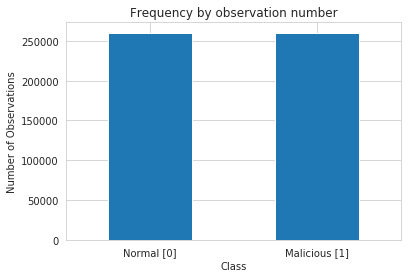

In [9]:
count_classes.plot(kind = 'bar', rot=0)
plt.xticks(range(2), ['Normal [0]','Malicious [1]'])
plt.title("Frequency by observation number")
plt.xlabel("Class")
plt.ylabel("Number of Observations");

In [10]:
#set random seed and percentage of test data
RANDOM_SEED = 23 #used to help randomly select the data points
TEST_PCT = 0.20 # 20% of the data

In [11]:
train, test_df = train_test_split(df, test_size=TEST_PCT, random_state=RANDOM_SEED)

+ df -> original dataset 
+ train -> subset of 80% from original dataset 
+ test_df -> subset of 20% from original dataset 

In [12]:
train_df, dev_df = train_test_split(train, test_size=TEST_PCT, random_state=RANDOM_SEED)

+ train -> subset of 80% from original dataset 
+ train_df -> subset of 80% from train
+ dev_df -> subset of 20% from train

In [15]:
# Check distribution of mal samples in train and test set
print(train_df.iloc[:, 120].sum()/train_df.shape[0]) 
print(dev_df.iloc[:, 120].sum()/dev_df.shape[0]) 
print(test_df.iloc[:, 120].sum()/test_df.shape[0])

0.5004261167559911
0.4992017860786691
0.4992750074419766


In [16]:
train_x = train_df.iloc[:, :120] 
dev_x = dev_df.iloc[:, :120] 
test_x = test_df.iloc[:, :120] 

+ train_x -> features of train_df **Training subset for AE**
+ dev_x -> features of dev_df **Validation subset for AE**
+ test_x -> features of test_df **Testing subset for ANN**

In [17]:
# Define the final train and test sets
train_y = train_df.iloc[:,120]
dev_y = dev_df.iloc[:,120]
test_y = test_df.iloc[:,120]

+ train_y -> **Labels for supervised training of ANN**
+ dev_y -> labels of dev_df  *not used for AE neither ANN*
+ test_y -> labels of test_df  **Ground Truth for predictions of supervised ANN**

In [18]:
train_x =np.array(train_x)
dev_x =np.array(dev_x)
test_x = np.array(test_x)

train_y = np.array(train_y)
dev_y = np.array(dev_y)
test_y = np.array(test_y)

print(train_x.shape[1])

120


### Autoencoder Function

encoding_dim - 2

Epoch 94/300 78596/78596 [==============================] - 10s 125us/step 
- loss: 3.8990e-05 - acc: 0.0237 - 
        val_loss: 3.9704e-05 - val_acc: 0.0236

In [29]:
def ae(factor_enc_dim, enc_activation, dec_activation, 
                optimizer, loss):

    encoding_dim = int(int(train_x.shape[1])/factor_enc_dim)
    ### Define input layer
    input_data = Input(shape=(train_x.shape[1],))
    ### Define encoding layer #RELU
    encoded = Dense(encoding_dim, activation=enc_activation, name='encoded_bottle_neck')(input_data)
    ### Define decoding layer #SIMOID
    decoded = Dense(train_x.shape[1], activation=dec_activation)(encoded)
    ### Create the autoencoder model
    autoencoder = Model(input_data, decoded)
    autoencoder.compile(optimizer=optimizer,
                        loss=loss,
                        metrics=['accuracy'])
    
    print(autoencoder.summary())
    
    encoder = Model(input_data, encoded)
    encoded_train_x = encoder.predict(train_x)
    encoded_test_x = encoder.predict(test_x)
    
    return autoencoder,encoded_train_x,encoded_test_x

In [30]:
def sae(factor_enc_dim, output_activation,
        optimizer, loss):

    encoding_dim = int(int(train_x.shape[1])/factor_enc_dim)
    ### Define input layer
    input_data = Input(shape=(train_x.shape[1],))
    ### Define encoding layer
    encoded = Dense(encoding_dim, activation='relu', name='input_layer')(input_data)
    encoded = Dense(int(encoding_dim/2), activation='relu')(encoded) ##Stacked AE
    encoded_bottle_neck = Dense(int(encoding_dim/4), activation='relu', name='enc_bottle_neck')(encoded) ##Stacked AE
    
    ### Define decoding layer
    decoded = Dense(int(encoding_dim/2), activation='relu')(encoded_bottle_neck) ##Stacked AE
    decoded = Dense(encoding_dim, activation='relu')(decoded) ##Stacked AE
    decoded = Dense(train_x.shape[1], activation=output_activation)(decoded)
    
    ### Create the autoencoder model
    sae = Model(input_data, decoded)
    sae.compile(optimizer=optimizer,
                loss=loss,
                metrics=['accuracy'])
    
    print(sae.summary())

    encoder = Model(input_data, encoded_bottle_neck)
    encoded_train_x = encoder.predict(train_x)
    encoded_test_x = encoder.predict(test_x)
    
    return sae,encoded_train_x,encoded_test_x

In [31]:
def spae(factor_enc_dim, output_activation, 
                optimizer, loss):

    encoding_dim = int(int(train_x.shape[1])/factor_enc_dim)
    ### Define input layer
    input_data = Input(shape=(train_x.shape[1],))
    ### Define encoding layer
    encoded = Dense(encoding_dim, activity_regularizer=regularizers.l1(1e-4), activation='relu', name='encoded_bottle_neck')(input_data)
    ### Define decoding layer
    decoded = Dense(train_x.shape[1], activation=output_activation)(encoded)
    ### Create the autoencoder model
    autoencoder = Model(input_data, decoded)
    autoencoder.compile(optimizer=optimizer,
                        loss=loss,
                        metrics=['accuracy'])
    
    print(autoencoder.summary())
    
    encoder = Model(input_data, encoded)
    encoded_train_x = encoder.predict(train_x)
    encoded_test_x = encoder.predict(test_x)
    
    return autoencoder,encoded_train_x,encoded_test_x

In [32]:
def fit_ae(checkpoint_file, autoencoder,
           epochs, batch_size, shuffle):
    
    early_stopping = EarlyStopping(monitor='val_loss', patience=5)

    cp = ModelCheckpoint(filepath=checkpoint_file,
                                   save_best_only=True,
                                   verbose=0)

    tb = TensorBoard(log_dir='./logs',
                    histogram_freq=0,
                    write_graph=True,
                    write_images=True)

    start_time = time.time()
    print(time.ctime(start_time))

    hist_auto = autoencoder.fit(train_x, train_x,
                    epochs=epochs,
                    batch_size=batch_size,
                    shuffle=shuffle,
                    verbose=1,
                    callbacks=[early_stopping, cp, tb],
                    validation_data=(dev_x, dev_x))

    elapsed_time = (time.time() - start_time)
    print("--- AE spent %s seconds ---" % elapsed_time)
    
    return hist_auto

In [33]:
def plot_hist_auto(hist_auto, fig_file):
    best_loss_value = hist_auto.history['loss'][-1]
    print('Best loss value:', best_loss_value)

    # Summarize history for loss
    plt.figure()
    plt.plot(hist_auto.history['loss'])
    plt.plot(hist_auto.history['val_loss'])
    plt.title('Autoencoder model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper right')
    plt.savefig(fig_file)
    plt.show()
    
    return best_loss_value

In [34]:
def ann_2h(neurons,encoded_train_x,init_mode,activation_input,
               weight_constraint,dropout_rate,activation_output,
               loss,optimizer):

    # create model
    model = Sequential()

    model.add(Dense(neurons, input_dim=encoded_train_x.shape[1],
                    kernel_initializer=init_mode,
                    #kernel_regularizer=regularizers.l2(0.02), #from example
                    activation=activation_input,
                    kernel_constraint=maxnorm(weight_constraint)
                    )
              )

#     #Hidden Layer
    model.add(Dense(90, activation="relu", kernel_initializer=init_mode)) #rezvy

    model.add(Dense(60, activation="relu", kernel_initializer=init_mode)) #rezvy
    model.add(BatchNormalization()) #commented for ex
    model.add(Dropout(dropout_rate))
    
    model.add(Dense(1, activation=activation_output)) #example
    
    # Compile model
    model.compile(loss=loss, 
                  optimizer=optimizer, 
                  metrics=['accuracy'])
    
    print(model.summary())
    
    return model

In [35]:
def ann_2h_(neurons,encoded_train_x,init_mode,activation_input,
               dropout_rate,activation_output,
               loss,lr):

    # create model
    model = Sequential()

    model.add(Dense(neurons, input_dim=encoded_train_x.shape[1],
                    kernel_initializer=init_mode,
                    #kernel_regularizer=regularizers.l2(0.02), #from example
                    activation=activation_input,
#                     kernel_constraint=maxnorm(weight_constraint)
#                     kernel_constraint=maxnorm(weight_constraint)
                    )
              )

#     #Hidden Layer
    model.add(Dense(90, activation="relu")) #rezvy

    model.add(Dense(60, activation="relu")) #rezvy
    model.add(BatchNormalization()) #commented for ex
    model.add(Dropout(dropout_rate))
    
    model.add(Dense(1, activation=activation_output)) #example

    optimizer = optimizers.Adam(lr=lr)
    
    # Compile model
    model.compile(loss=loss, 
                  optimizer=optimizer, 
                  metrics=['accuracy'])
    
    print(model.summary())
    
    return model

In [36]:
def ann_2h__(neurons,encoded_train_x,activation_input,
             activation_output,loss,optimizer):

    # create model
    model = Sequential()

    model.add(Dense(neurons, input_dim=encoded_train_x.shape[1],
#                     kernel_initializer=init_mode,
                    #kernel_regularizer=regularizers.l2(0.02), #from example
                    activation=activation_input,
#                     kernel_constraint=maxnorm(weight_constraint)
#                     kernel_constraint=maxnorm(weight_constraint)
                    )
              )

#     #Hidden Layer
    model.add(Dense(90, activation="relu")) #rezvy

    model.add(Dense(60, activation="relu")) #rezvy
#     model.add(BatchNormalization()) #commented for ex
#     model.add(Dropout(dropout_rate))
    
    model.add(Dense(1, activation=activation_output)) #example

#     optimizer = optimizers.Adam(lr=lr)
    
    # Compile model
    model.compile(loss=loss, 
                  optimizer=optimizer, 
                  metrics=['accuracy'])
    
    print(model.summary())
    
    return model

In [37]:
def ann_1h_36n(neurons,encoded_train_x,init_mode,activation_input,
               weight_constraint,dropout_rate,activation_output,
               loss,optimizer):

    # create model
    model = Sequential()

    model.add(Dense(neurons, input_dim=encoded_train_x.shape[1],
                    kernel_initializer=init_mode,
                    #kernel_regularizer=regularizers.l2(0.02), #from example
                    activation=activation_input,
                    kernel_constraint=maxnorm(weight_constraint)
                    )
              )

#     #Hidden Layer
    model.add(Dense(90, activation="relu", kernel_initializer=init_mode)) #rezvy
    model.add(BatchNormalization()) #commented for ex
    model.add(Dropout(dropout_rate))
    
    model.add(Dense(1, activation=activation_output)) #example
    
    # Compile model
    model.compile(loss=loss, 
                  optimizer=optimizer, 
                  metrics=['accuracy'])
    
    print(model.summary())
    
    return model

In [38]:
def ann_1h_24n(neurons,encoded_train_x,init_mode,activation_input,
               weight_constraint,dropout_rate,activation_output,
               loss,optimizer):

    # create model
    model = Sequential()

    model.add(Dense(neurons, input_dim=encoded_train_x.shape[1],
                    kernel_initializer=init_mode,
                    #kernel_regularizer=regularizers.l2(0.02), #from example
                    activation=activation_input,
                    kernel_constraint=maxnorm(weight_constraint)
                    )
              )

#     #Hidden Layer
    model.add(Dense(60, activation="relu", kernel_initializer=init_mode)) #rezvy
    model.add(BatchNormalization()) #commented for ex
    model.add(Dropout(dropout_rate))
    
    model.add(Dense(1, activation=activation_output)) #example
    
    # Compile model
    model.compile(loss=loss, 
                  optimizer=optimizer, 
                  metrics=['accuracy'])
    
    print(model.summary())
    
    return model

In [39]:
def ann_1h_24n_(neurons,encoded_train_x,activation_input,
               activation_output,loss,optimizer):

    # create model
    model = Sequential()

    model.add(Dense(neurons, input_dim=encoded_train_x.shape[1],
#                     kernel_initializer=init_mode,
                    #kernel_regularizer=regularizers.l2(0.02), #from example
                    activation=activation_input,
#                     kernel_constraint=maxnorm(weight_constraint)
                    )
              )

#     #Hidden Layer
    model.add(Dense(60, activation="relu")) #rezvy
    
#     model.add(BatchNormalization()) #commented for ex
#     model.add(Dropout(dropout_rate))
    
    model.add(Dense(1, activation=activation_output)) #example
    
    # Compile model
    model.compile(loss=loss, 
                  optimizer=optimizer, 
                  metrics=['accuracy'])
    
    print(model.summary())
    
    return model

In [40]:
def ann_fit(checkpoint_file,ann,enc_train_x,train_y,epochs,shuffle,batch_size):
    early_stopping = EarlyStopping(monitor='val_loss', patience=5)

    cp = ModelCheckpoint(filepath=checkpoint_file,
                                   save_best_only=True,
                                   verbose=0)

    tb = TensorBoard(log_dir='./logs',
                    histogram_freq=0,
                    write_graph=True,
                    write_images=True)

    start_time = time.time()
    print(time.ctime(start_time))

    history = ann.fit(enc_train_x,
                      train_y,
                      validation_split=0.2,
                      callbacks=[early_stopping],
                      epochs=epochs,
                      shuffle=shuffle,
                      batch_size=batch_size,
                      verbose=1)

    elapsed_time = (time.time() - start_time)
    print("--- ANN spent %s seconds ---" % elapsed_time)

    return history

In [141]:
def ann_predict(ann,enc_test_x):
    pred_ann_prob = ann.predict(enc_test_x)
    pred_ann_prob.shape
    pred_ann_prob = pred_ann_prob[:,0]
    pred_ann_01 = np.where(pred_ann_prob > 0.5, 1, 0)
    
    #Print accuracy
    acc_ann = accuracy_score(test_y, pred_ann_01)
    print('Overall accuracy of Neural Network model:', acc_ann)

    classiBM = "NN"
    preBM = (sm.precision_score(test_y, pred_ann_01)*100) 
    recallBM = (sm.recall_score(test_y, pred_ann_01)*100) 
    f1scoreBM = (sm.f1_score(test_y, pred_ann_01)*100)
    print(sm.classification_report(test_y, pred_ann_01,digits=4))
    
    return pred_ann_prob, pred_ann_01

In [42]:
def plot_roc_cm(pred_ann_prob, pred_ann_01, roc_file, cm_file):
    false_positive_rate, recall, thresholds = roc_curve(test_y, pred_ann_prob)
    roc_auc = auc(false_positive_rate, recall)
    plt.figure()
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.plot(false_positive_rate, recall, 'b', label = 'AUC = %0.3f' %roc_auc)
    plt.legend(loc='lower right')
    plt.plot([0,1], [0,1], 'r--')
    plt.xlim([0.0,1.0])
    plt.ylim([0.0,1.0])
    plt.ylabel('Recall')
    plt.xlabel('Fall-out (1-Specificity)')
    plt.savefig(roc_file)
    plt.show()
    
    cm = confusion_matrix(test_y, pred_ann_01)
    labels = ['Normal', 'Malicious']
    plt.figure(figsize=(8,6))
    sns.heatmap(cm,xticklabels=labels, yticklabels=labels, annot=True, fmt='d', cmap="RdYlGn", vmin = 0.2);
    plt.title('Confusion Matrix')
    plt.ylabel('True Class')
    plt.xlabel('Predicted Class')
    plt.savefig(cm_file)
    plt.show()
    

loss: 2.7516e-05 - acc: 0.0407 

val_loss: 2.7072e-05 - val_acc: 0.0399

In [43]:
ae_sigmoid_adam_logcosh,enc_train_x_asal,enc_test_x_asal = ae(factor_enc_dim = 1.5,
                                                              enc_activation = 'relu',
                                                              dec_activation = 'sigmoid',
                                                              optimizer='Adam',
                                                              loss='logcosh')

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 120)               0         
_________________________________________________________________
encoded_bottle_neck (Dense)  (None, 80)                9680      
_________________________________________________________________
dense_1 (Dense)              (None, 120)               9720      
Total params: 19,400
Trainable params: 19,400
Non-trainable params: 0
_________________________________________________________________
None


In [44]:
#ae_sigmoid_adam_logcosh = load_model('ae_sigmoid_adam_logcosh_redds10bal.h5')

In [45]:
hist_ae_sigmoid_adam_logcosh = fit_ae(checkpoint_file = "ae_sigmoid_adam_logcosh_redds10bal.h5",
                                        autoencoder = ae_sigmoid_adam_logcosh, 
                                        epochs = 200, 
                                        batch_size = 120, 
                                        shuffle = False)

Sun Jun  9 10:18:44 2019
Instructions for updating:
Use tf.cast instead.
Train on 333242 samples, validate on 83311 samples
Epoch 1/200
333242/333242 [==============================] - 6s 18us/step - loss: 0.0340 - acc: 0.2687 - val_loss: 0.0288 - val_acc: 0.3434
Epoch 2/200
333242/333242 [==============================] - 6s 17us/step - loss: 0.0284 - acc: 0.3459 - val_loss: 0.0282 - val_acc: 0.3749
Epoch 3/200
333242/333242 [==============================] - 6s 17us/step - loss: 0.0282 - acc: 0.3331 - val_loss: 0.0281 - val_acc: 0.3316
Epoch 4/200
333242/333242 [==============================] - 6s 17us/step - loss: 0.0282 - acc: 0.3005 - val_loss: 0.0281 - val_acc: 0.3063
Epoch 5/200
333242/333242 [==============================] - 6s 17us/step - loss: 0.0282 - acc: 0.2796 - val_loss: 0.0281 - val_acc: 0.2502
Epoch 6/200
333242/333242 [==============================] - 5s 16us/step - loss: 0.0282 - acc: 0.2470 - val_loss: 0.0281 - val_acc: 0.2382
Epoch 7/200
333242/333242 [=========

Best loss value: 0.02809491245759462


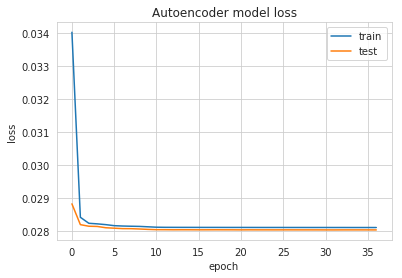

In [46]:
best_loss_value_ae_sigmoid_adam_logcosh = plot_hist_auto(hist_ae_sigmoid_adam_logcosh, './Figures/ae_sigmoid_adam_logcosh.png')

In [47]:
ae_siglin_adam_logcosh,enc_train_x_aslal,enc_test_x_aslal = ae(factor_enc_dim = 1.5,
                                                              enc_activation = 'sigmoid',
                                                              dec_activation = 'linear',
                                                              optimizer='Adam',
                                                              loss='logcosh')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 120)               0         
_________________________________________________________________
encoded_bottle_neck (Dense)  (None, 80)                9680      
_________________________________________________________________
dense_2 (Dense)              (None, 120)               9720      
Total params: 19,400
Trainable params: 19,400
Non-trainable params: 0
_________________________________________________________________
None


In [48]:
#ae_siglin_adam_logcosh = load_model('ae_siglin_adam_logcosh_redds10bal.h5')

In [49]:
hist_ae_siglin_adam_logcosh = fit_ae(checkpoint_file = "ae_siglin_adam_logcosh_redds10bal.h5",
                                        autoencoder = ae_siglin_adam_logcosh, 
                                        epochs = 200, 
                                        batch_size = 120, 
                                        shuffle = False)

Sun Jun  9 10:22:15 2019
Train on 333242 samples, validate on 83311 samples
Epoch 1/200
333242/333242 [==============================] - 6s 17us/step - loss: 0.0059 - acc: 0.6835 - val_loss: 0.0012 - val_acc: 0.7682
Epoch 2/200
333242/333242 [==============================] - 6s 17us/step - loss: 9.6821e-04 - acc: 0.8003 - val_loss: 9.1092e-04 - val_acc: 0.7837
Epoch 3/200
333242/333242 [==============================] - 6s 17us/step - loss: 8.0397e-04 - acc: 0.8202 - val_loss: 8.4640e-04 - val_acc: 0.7504
Epoch 4/200
333242/333242 [==============================] - 6s 17us/step - loss: 7.3921e-04 - acc: 0.8340 - val_loss: 8.0847e-04 - val_acc: 0.7659
Epoch 5/200
333242/333242 [==============================] - 6s 17us/step - loss: 6.9789e-04 - acc: 0.8355 - val_loss: 7.8006e-04 - val_acc: 0.7733
Epoch 6/200
333242/333242 [==============================] - 6s 17us/step - loss: 6.6591e-04 - acc: 0.8350 - val_loss: 7.5277e-04 - val_acc: 0.7728
Epoch 7/200
333242/333242 [=================

Best loss value: 0.0005388572285658796


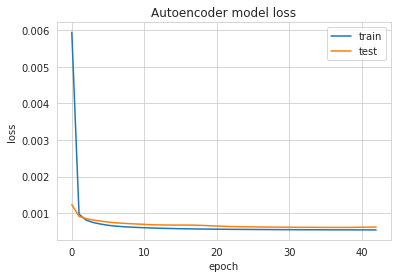

In [50]:
best_loss_value_ae_siglin_adam_logcosh = plot_hist_auto(hist_ae_siglin_adam_logcosh, './Figures/hist_ae_siglin_adam_logcosh.png')

In [51]:
ae_sigmoid_adam_mse,enc_train_x_asam,enc_test_x_asam = ae(factor_enc_dim = 1.5,
                                                          enc_activation = 'relu',
                                                          dec_activation = 'sigmoid',
                                                          optimizer='Adam',
                                                          loss='mean_squared_error')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 120)               0         
_________________________________________________________________
encoded_bottle_neck (Dense)  (None, 80)                9680      
_________________________________________________________________
dense_3 (Dense)              (None, 120)               9720      
Total params: 19,400
Trainable params: 19,400
Non-trainable params: 0
_________________________________________________________________
None


In [52]:
#ae_sigmoid_adam_mse = load_model('ae_sigmoid_adam_mse_redds10bal.h5')

In [53]:
hist_ae_sigmoid_adam_mse = fit_ae(checkpoint_file = "ae_sigmoid_adam_mse_redds10bal.h5",
                                  autoencoder = ae_sigmoid_adam_mse, 
                                  epochs = 200, 
                                  batch_size = 120,
                                  shuffle = False)

Sun Jun  9 10:26:23 2019
Train on 333242 samples, validate on 83311 samples
Epoch 1/200
333242/333242 [==============================] - 6s 19us/step - loss: 0.0980 - acc: 0.2193 - val_loss: 0.0830 - val_acc: 0.2675
Epoch 2/200
333242/333242 [==============================] - 6s 19us/step - loss: 0.0863 - acc: 0.2829 - val_loss: 0.0824 - val_acc: 0.3059
Epoch 3/200
333242/333242 [==============================] - 6s 19us/step - loss: 0.0860 - acc: 0.2829 - val_loss: 0.0823 - val_acc: 0.2614
Epoch 4/200
333242/333242 [==============================] - 6s 19us/step - loss: 0.0859 - acc: 0.2536 - val_loss: 0.0822 - val_acc: 0.2304
Epoch 5/200
333242/333242 [==============================] - 6s 19us/step - loss: 0.0859 - acc: 0.2182 - val_loss: 0.0822 - val_acc: 0.2102
Epoch 6/200
333242/333242 [==============================] - 6s 19us/step - loss: 0.0859 - acc: 0.2057 - val_loss: 0.0822 - val_acc: 0.1893
Epoch 7/200
333242/333242 [==============================] - 6s 19us/step - loss: 0.

Best loss value: 0.08587701282051359


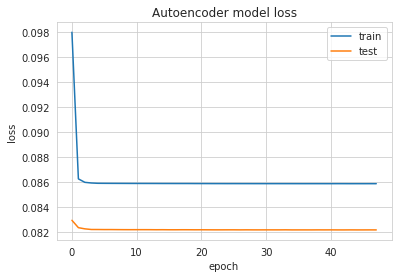

In [54]:
best_loss_value_ae_sigmoid_adam_mse  = plot_hist_auto(hist_ae_sigmoid_adam_mse, './Figures/hist_ae_sigmoid_adam_mse.png')

In [55]:
ae_sigsig_adam_logcosh,enc_train_x_assal,enc_test_x_assal = ae(factor_enc_dim = 1.5,
                                                          enc_activation = 'sigmoid',
                                                          dec_activation = 'sigmoid',
                                                          optimizer='Adam',
                                                          loss='logcosh')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 120)               0         
_________________________________________________________________
encoded_bottle_neck (Dense)  (None, 80)                9680      
_________________________________________________________________
dense_4 (Dense)              (None, 120)               9720      
Total params: 19,400
Trainable params: 19,400
Non-trainable params: 0
_________________________________________________________________
None


In [56]:
#ae_sigsig_adam_logcosh = load_model('ae_sigsig_adam_logcosh_redds10bal.h5')

In [57]:
hist_ae_sigsig_adam_logcosh = fit_ae(checkpoint_file = "ae_sigsig_adam_logcosh_redds10bal.h5",
                                  autoencoder = ae_sigsig_adam_logcosh, 
                                  epochs = 200, 
                                  batch_size = 120,
                                  shuffle = False)

Sun Jun  9 10:31:30 2019
Train on 333242 samples, validate on 83311 samples
Epoch 1/200
333242/333242 [==============================] - 7s 20us/step - loss: 0.0387 - acc: 0.1548 - val_loss: 0.0336 - val_acc: 0.3130
Epoch 2/200
333242/333242 [==============================] - 7s 20us/step - loss: 0.0316 - acc: 0.3785 - val_loss: 0.0297 - val_acc: 0.4110
Epoch 3/200
333242/333242 [==============================] - 7s 20us/step - loss: 0.0289 - acc: 0.4037 - val_loss: 0.0283 - val_acc: 0.3920
Epoch 4/200
333242/333242 [==============================] - 7s 20us/step - loss: 0.0283 - acc: 0.3842 - val_loss: 0.0281 - val_acc: 0.3834
Epoch 5/200
333242/333242 [==============================] - 7s 20us/step - loss: 0.0282 - acc: 0.3763 - val_loss: 0.0281 - val_acc: 0.3733
Epoch 6/200
333242/333242 [==============================] - 7s 20us/step - loss: 0.0282 - acc: 0.3589 - val_loss: 0.0281 - val_acc: 0.3508
Epoch 7/200
333242/333242 [==============================] - 7s 20us/step - loss: 0.

Best loss value: 0.028086658293596942


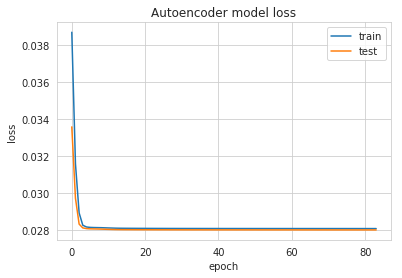

In [58]:
best_loss_value_ae_sigsig_adam_logcosh  = plot_hist_auto(hist_ae_sigsig_adam_logcosh, './Figures/hist_ae_sigsig_adam_logcosh.png')

In [59]:
loss_valueDict = {
    'loss_value_ae_sigmoid_adam_logcosh': best_loss_value_ae_sigmoid_adam_logcosh,
    'loss_value_ae_sigmoid_adam_mse': best_loss_value_ae_sigmoid_adam_mse,
    'loss_value_ae_siglin_adam_logcosh': best_loss_value_ae_siglin_adam_logcosh,
    'loss_value_ae_sigsig_adam_logcosh': best_loss_value_ae_sigsig_adam_logcosh
    }

In [60]:
loss_valueDict

{'loss_value_ae_sigmoid_adam_logcosh': 0.02809491245759462,
 'loss_value_ae_sigmoid_adam_mse': 0.08587701282051359,
 'loss_value_ae_siglin_adam_logcosh': 0.0005388572285658796,
 'loss_value_ae_sigsig_adam_logcosh': 0.028086658293596942}

In [61]:
print(enc_train_x_asal.shape)
print(enc_test_x_asal.shape)

print(enc_train_x_asam.shape)
print(enc_test_x_asam.shape)

print(enc_train_x_aslal.shape)
print(enc_test_x_aslal.shape)

print(enc_train_x_assal.shape)
print(enc_test_x_assal.shape)

(333242, 80)
(104139, 80)
(333242, 80)
(104139, 80)
(333242, 80)
(104139, 80)
(333242, 80)
(104139, 80)


#### ====================== Fail ANN ======================

In [62]:
ann36n_unisoftsigbinlosadam = ann_1h_36n(neurons=120,
                                      encoded_train_x=enc_train_x_asal,
                                      init_mode='uniform',
                                      activation_input='softsign',
                                      weight_constraint=5,
                                      dropout_rate=0.0,
                                      activation_output='sigmoid',
                                      loss='binary_crossentropy',
                                      optimizer='Adam')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 120)               9720      
_________________________________________________________________
dense_6 (Dense)              (None, 90)                10890     
_________________________________________________________________
batch_normalization_1 (Batch (None, 90)                360       
_________________________________________________________________
dropout_1 (Dropout)          (None, 90)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 91        
Total params: 21,061
Trainable params: 20,881
Non-trainable params: 180
_________________________________________________________________
None


In [63]:
hist_ann36n_unisoftsigbinlosadam = ann_fit(checkpoint_file = "ann36n_unisoftsigbinlosadam_redds10bal.h5",
                                        ann = ann36n_unisoftsigbinlosadam,
                                        enc_train_x = enc_train_x_asal,
                                        train_y = train_y,
                                        epochs = 200,
                                        shuffle = True,
                                        batch_size = 120)

Sun Jun  9 10:40:30 2019
Train on 266593 samples, validate on 66649 samples
Epoch 1/200
266593/266593 [==============================] - 9s 35us/step - loss: 0.1358 - acc: 0.9476 - val_loss: 0.0556 - val_acc: 0.9790
Epoch 2/200
266593/266593 [==============================] - 9s 33us/step - loss: 0.0432 - acc: 0.9840 - val_loss: 0.0476 - val_acc: 0.9823
Epoch 3/200
266593/266593 [==============================] - 9s 33us/step - loss: 0.0322 - acc: 0.9876 - val_loss: 0.0311 - val_acc: 0.9866
Epoch 4/200
266593/266593 [==============================] - 9s 33us/step - loss: 0.0263 - acc: 0.9899 - val_loss: 0.0288 - val_acc: 0.9889
Epoch 5/200
266593/266593 [==============================] - 9s 33us/step - loss: 0.0239 - acc: 0.9908 - val_loss: 0.0202 - val_acc: 0.9932
Epoch 6/200
266593/266593 [==============================] - 9s 32us/step - loss: 0.0207 - acc: 0.9918 - val_loss: 0.0243 - val_acc: 0.9902
Epoch 7/200
266593/266593 [==============================] - 9s 33us/step - loss: 0.

Best loss value: 0.010483377829279173


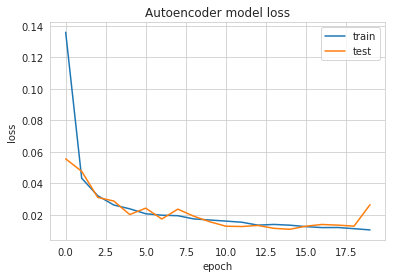

In [64]:
best_loss_value_ann36n_unisoftsigbinlosadam = plot_hist_auto(hist_ann36n_unisoftsigbinlosadam, './Figures/ann36_unisoftsigbinlosadam.png')

In [65]:
pred_ann36n_prob_unisoftsigbinlosadam, pred_ann36n_01_unisoftsigbinlosadam = ann_predict(ann36n_unisoftsigbinlosadam,enc_test_x_asal)

Overall accuracy of Neural Network model: 0.9933454325468845
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     52145
           1       1.00      0.99      0.99     51994

   micro avg       0.99      0.99      0.99    104139
   macro avg       0.99      0.99      0.99    104139
weighted avg       0.99      0.99      0.99    104139



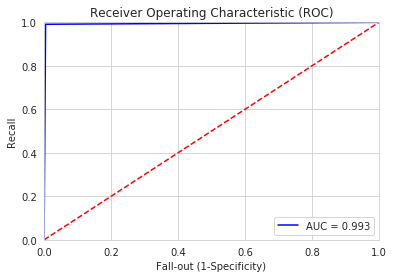

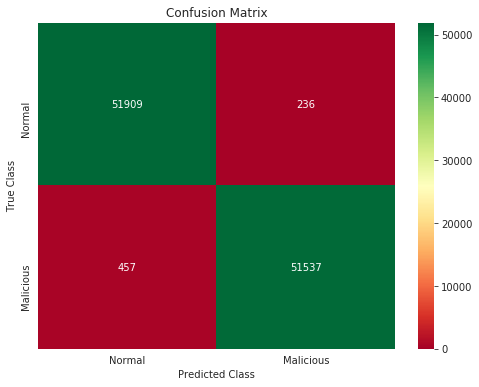

In [66]:
plot_roc_cm(pred_ann36n_01_unisoftsigbinlosadam, pred_ann36n_01_unisoftsigbinlosadam, './Figures/ROC_ann36n_unisoftsigbinlosadam_redds10bal.png', './Figures/CM_ann36n_unisoftsigbinlosadam_redds10bal.png')

In [67]:
ann36n_unisoftsigbinlosadam2 = ann_1h_36n(neurons=120,
                                      encoded_train_x=enc_train_x_asam,
                                      init_mode='uniform',
                                      activation_input='softsign',
                                      weight_constraint=5,
                                      dropout_rate=0.0,
                                      activation_output='sigmoid',
                                      loss='binary_crossentropy',
                                      optimizer='Adam')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 120)               9720      
_________________________________________________________________
dense_9 (Dense)              (None, 90)                10890     
_________________________________________________________________
batch_normalization_2 (Batch (None, 90)                360       
_________________________________________________________________
dropout_2 (Dropout)          (None, 90)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 91        
Total params: 21,061
Trainable params: 20,881
Non-trainable params: 180
_________________________________________________________________
None


In [68]:
hist_ann36n_unisoftsigbinlosadam2 = ann_fit(checkpoint_file = "ann36n_unisoftsigbinlosadam2_redds10bal.h5",
                                        ann = ann36n_unisoftsigbinlosadam2,
                                        enc_train_x = enc_train_x_asam,
                                        train_y = train_y,
                                        epochs = 200,
                                        shuffle = True,
                                        batch_size = 120)

Sun Jun  9 10:43:27 2019
Train on 266593 samples, validate on 66649 samples
Epoch 1/200
266593/266593 [==============================] - 9s 35us/step - loss: 0.1440 - acc: 0.9435 - val_loss: 0.0433 - val_acc: 0.9854
Epoch 2/200
266593/266593 [==============================] - 9s 33us/step - loss: 0.0445 - acc: 0.9839 - val_loss: 0.0445 - val_acc: 0.9816
Epoch 3/200
266593/266593 [==============================] - 9s 33us/step - loss: 0.0355 - acc: 0.9870 - val_loss: 0.0255 - val_acc: 0.9907
Epoch 4/200
266593/266593 [==============================] - 9s 33us/step - loss: 0.0284 - acc: 0.9895 - val_loss: 0.0215 - val_acc: 0.9926
Epoch 5/200
266593/266593 [==============================] - 9s 33us/step - loss: 0.0251 - acc: 0.9904 - val_loss: 0.0223 - val_acc: 0.9911
Epoch 6/200
266593/266593 [==============================] - 9s 33us/step - loss: 0.0221 - acc: 0.9916 - val_loss: 0.0196 - val_acc: 0.9937
Epoch 7/200
266593/266593 [==============================] - 9s 33us/step - loss: 0.

Best loss value: 0.012293776911330073


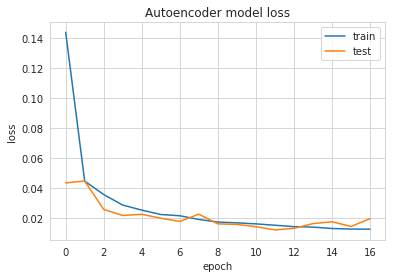

In [69]:
best_loss_value_ann36n_unisoftsigbinlosadam2 = plot_hist_auto(hist_ann36n_unisoftsigbinlosadam2, './Figures/ann36_unisoftsigbinlosadam2.png')

In [70]:
pred_ann36n_prob_unisoftsigbinlosadam, pred_ann36n_01_unisoftsigbinlosadam2 = ann_predict(ann36n_unisoftsigbinlosadam2,enc_test_x_asam)

Overall accuracy of Neural Network model: 0.9934606631521332
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     52145
           1       0.99      0.99      0.99     51994

   micro avg       0.99      0.99      0.99    104139
   macro avg       0.99      0.99      0.99    104139
weighted avg       0.99      0.99      0.99    104139



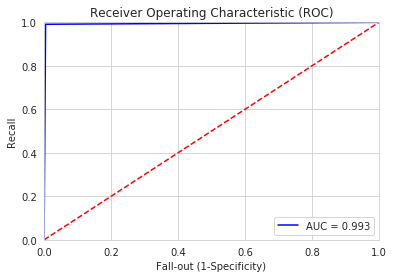

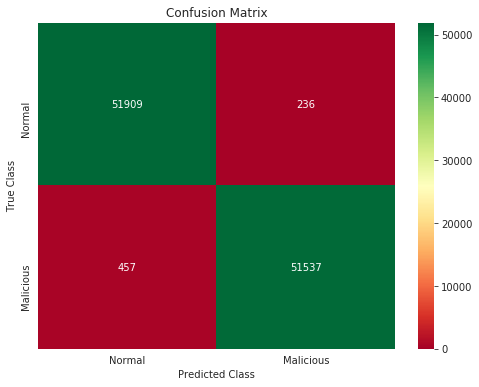

In [71]:
plot_roc_cm(pred_ann36n_01_unisoftsigbinlosadam, pred_ann36n_01_unisoftsigbinlosadam, './Figures/ROC_ann36n_unisoftsigbinlosadam_redds10bal.png', './Figures/CM_ann36n_unisoftsigbinlosadam_redds10bal.png')

In [72]:
ann24n_unisoftsigbinlosadam = ann_1h_24n(neurons=120,
                                      encoded_train_x=enc_train_x_asam,
                                      init_mode='uniform',
                                      activation_input='softsign',
                                      weight_constraint=5,
                                      dropout_rate=0.0,
                                      activation_output='sigmoid',
                                      loss='binary_crossentropy',
                                      optimizer='Adam')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_11 (Dense)             (None, 120)               9720      
_________________________________________________________________
dense_12 (Dense)             (None, 60)                7260      
_________________________________________________________________
batch_normalization_3 (Batch (None, 60)                240       
_________________________________________________________________
dropout_3 (Dropout)          (None, 60)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 61        
Total params: 17,281
Trainable params: 17,161
Non-trainable params: 120
_________________________________________________________________
None


In [73]:
hist_ann24n_unisoftsigbinlosadam = ann_fit(checkpoint_file = "ann24n_unisoftsigbinlosadam_redds10bal.h5",
                                        ann = ann24n_unisoftsigbinlosadam,
                                        enc_train_x = enc_train_x_asam,
                                        train_y = train_y,
                                        epochs = 200,
                                        shuffle = True,
                                        batch_size = 120)

Sun Jun  9 10:45:59 2019
Train on 266593 samples, validate on 66649 samples
Epoch 1/200
266593/266593 [==============================] - 9s 35us/step - loss: 0.1624 - acc: 0.9332 - val_loss: 0.0519 - val_acc: 0.9802
Epoch 2/200
266593/266593 [==============================] - 9s 33us/step - loss: 0.0490 - acc: 0.9814 - val_loss: 0.0469 - val_acc: 0.9818
Epoch 3/200
266593/266593 [==============================] - 9s 33us/step - loss: 0.0380 - acc: 0.9850 - val_loss: 0.0363 - val_acc: 0.9848
Epoch 4/200
266593/266593 [==============================] - 9s 33us/step - loss: 0.0312 - acc: 0.9878 - val_loss: 0.0334 - val_acc: 0.9869
Epoch 5/200
266593/266593 [==============================] - 9s 33us/step - loss: 0.0280 - acc: 0.9888 - val_loss: 0.0302 - val_acc: 0.9887
Epoch 6/200
266593/266593 [==============================] - 9s 32us/step - loss: 0.0254 - acc: 0.9899 - val_loss: 0.0252 - val_acc: 0.9901
Epoch 7/200
266593/266593 [==============================] - 9s 33us/step - loss: 0.

Best loss value: 0.013134351306585398


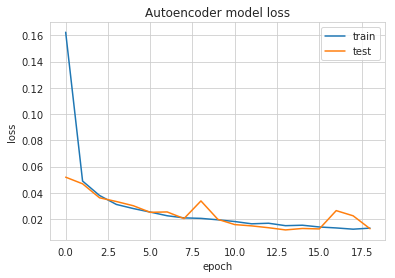

In [74]:
best_loss_value_ann24n_unisoftsigbinlosadam = plot_hist_auto(hist_ann24n_unisoftsigbinlosadam, './Figures/ann24_unisoftsigbinlosadam.png')

In [75]:
pred_ann24n_prob_unisoftsigbinlosadam, pred_ann24n_01_unisoftsigbinlosadam = ann_predict(ann24n_unisoftsigbinlosadam,enc_test_x_asam)

Overall accuracy of Neural Network model: 0.9946417768559329
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     52145
           1       0.99      1.00      0.99     51994

   micro avg       0.99      0.99      0.99    104139
   macro avg       0.99      0.99      0.99    104139
weighted avg       0.99      0.99      0.99    104139



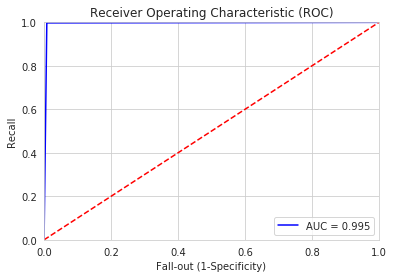

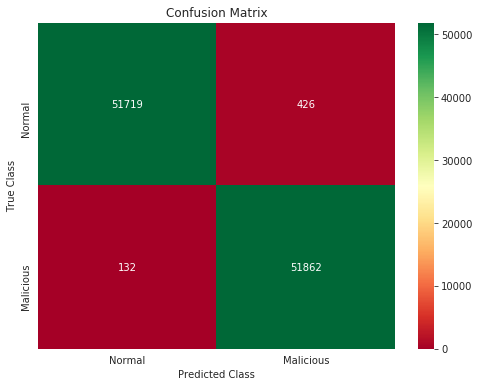

In [76]:
plot_roc_cm(pred_ann24n_01_unisoftsigbinlosadam, pred_ann24n_01_unisoftsigbinlosadam, './Figures/ROC_ann24n_unisoftsigbinlosadam_redds10bal.png', './Figures/CM_ann24n_unisoftsigbinlosadam_redds10bal.png')

In [77]:
ann_2h_unisoftsigbinlosadam = ann_2h(neurons=120,
                                      encoded_train_x=enc_train_x_asam,
                                      init_mode='uniform',
                                      activation_input='softsign',
                                      weight_constraint=5,
                                      dropout_rate=0.0,
                                      activation_output='sigmoid',
                                      loss='binary_crossentropy',
                                      optimizer='Adam')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_14 (Dense)             (None, 120)               9720      
_________________________________________________________________
dense_15 (Dense)             (None, 90)                10890     
_________________________________________________________________
dense_16 (Dense)             (None, 60)                5460      
_________________________________________________________________
batch_normalization_4 (Batch (None, 60)                240       
_________________________________________________________________
dropout_4 (Dropout)          (None, 60)                0         
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 61        
Total params: 26,371
Trainable params: 26,251
Non-trainable params: 120
_________________________________________________________________
None

In [78]:
hist_ann_2h_unisoftsigbinlosadam = ann_fit(checkpoint_file = "ann_2h_unisoftsigbinlosadam_redds10bal.h5",
                                        ann = ann_2h_unisoftsigbinlosadam,
                                        enc_train_x = enc_train_x_asam,
                                        train_y = train_y,
                                        epochs = 200,
                                        shuffle = True,
                                        batch_size = 120)

Sun Jun  9 10:48:50 2019
Train on 266593 samples, validate on 66649 samples
Epoch 1/200
266593/266593 [==============================] - 11s 40us/step - loss: 0.1260 - acc: 0.9456 - val_loss: 0.0364 - val_acc: 0.9843
Epoch 2/200
266593/266593 [==============================] - 10s 36us/step - loss: 0.0409 - acc: 0.9827 - val_loss: 0.0354 - val_acc: 0.9858
Epoch 3/200
266593/266593 [==============================] - 10s 36us/step - loss: 0.0309 - acc: 0.9873 - val_loss: 0.0369 - val_acc: 0.9872
Epoch 4/200
266593/266593 [==============================] - 10s 37us/step - loss: 0.0252 - acc: 0.9897 - val_loss: 0.0345 - val_acc: 0.9862
Epoch 5/200
266593/266593 [==============================] - 10s 37us/step - loss: 0.0224 - acc: 0.9909 - val_loss: 0.0146 - val_acc: 0.9942
Epoch 6/200
266593/266593 [==============================] - 10s 37us/step - loss: 0.0195 - acc: 0.9920 - val_loss: 0.0147 - val_acc: 0.9945
Epoch 7/200
266593/266593 [==============================] - 10s 36us/step - l

In [135]:
# hist_ann_2h_unisoftsigbinlosadam.model.get_weights()

Best loss value: 0.007210591557317957


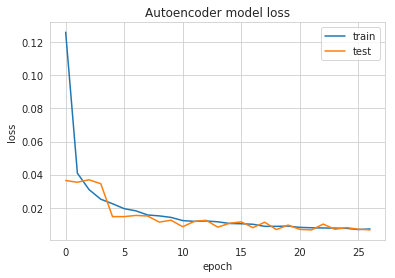

In [80]:
best_loss_value_ann_2h_unisoftsigbinlosadam = plot_hist_auto(hist_ann_2h_unisoftsigbinlosadam, './Figures/ann_2h_unisoftsigbinlosadam.png')

In [81]:
pred_ann_2h_prob_unisoftsigbinlosadam, pred_ann_2h_01_unisoftsigbinlosadam = ann_predict(ann_2h_unisoftsigbinlosadam,enc_test_x_asam)

Overall accuracy of Neural Network model: 0.9975513496384639
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     52145
           1       1.00      1.00      1.00     51994

   micro avg       1.00      1.00      1.00    104139
   macro avg       1.00      1.00      1.00    104139
weighted avg       1.00      1.00      1.00    104139



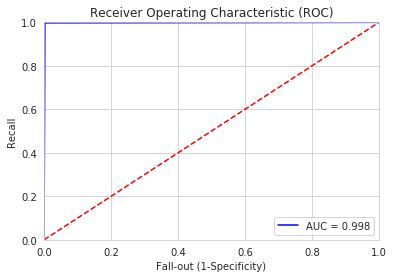

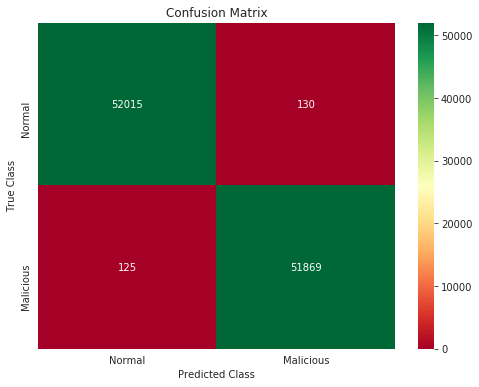

In [82]:
plot_roc_cm(pred_ann_2h_01_unisoftsigbinlosadam, pred_ann_2h_01_unisoftsigbinlosadam, './Figures/ROC_ann_2h_unisoftsigbinlosadam_redds10bal.png', './Figures/CM_ann_2h_unisoftsigbinlosadam_redds10bal.png')

In [83]:
ann_2h_unisoftsigbinlosadam2 = ann_2h_(neurons=120,
                                      encoded_train_x=enc_train_x_asal,
#                                       init_mode='glorot_uniform',
                                       init_mode='VarianceScaling',
#                                       activation_input='softsign',
                                      activation_input='relu',
#                                       weight_constraint=5,
                                      dropout_rate=0.0,
                                      activation_output='sigmoid',
                                      loss='binary_crossentropy',
                                      lr=0.05)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_18 (Dense)             (None, 120)               9720      
_________________________________________________________________
dense_19 (Dense)             (None, 90)                10890     
_________________________________________________________________
dense_20 (Dense)             (None, 60)                5460      
_________________________________________________________________
batch_normalization_5 (Batch (None, 60)                240       
_________________________________________________________________
dropout_5 (Dropout)          (None, 60)                0         
_________________________________________________________________
dense_21 (Dense)             (None, 1)                 61        
Total params: 26,371
Trainable params: 26,251
Non-trainable params: 120
_________________________________________________________________
None

In [84]:
hist_ann_2h_unisoftsigbinlosadam2 = ann_fit(checkpoint_file = "ann_2h_unisoftsigbinlosadam2_redds10bal.h5",
                                        ann = ann_2h_unisoftsigbinlosadam2,
                                        enc_train_x = enc_train_x_asal,
                                        train_y = train_y,
                                        epochs = 200,
                                        shuffle = True,
                                        batch_size = 120)

Sun Jun  9 10:53:15 2019
Train on 266593 samples, validate on 66649 samples
Epoch 1/200
266593/266593 [==============================] - 10s 39us/step - loss: 0.1793 - acc: 0.9204 - val_loss: 0.1795 - val_acc: 0.9545
Epoch 2/200
266593/266593 [==============================] - 10s 36us/step - loss: 0.0611 - acc: 0.9767 - val_loss: 0.0485 - val_acc: 0.9783
Epoch 3/200
266593/266593 [==============================] - 10s 36us/step - loss: 0.0482 - acc: 0.9818 - val_loss: 0.0323 - val_acc: 0.9876
Epoch 4/200
266593/266593 [==============================] - 10s 36us/step - loss: 0.0396 - acc: 0.9852 - val_loss: 0.0435 - val_acc: 0.9834
Epoch 5/200
266593/266593 [==============================] - 10s 36us/step - loss: 0.0351 - acc: 0.9865 - val_loss: 0.0347 - val_acc: 0.9841
Epoch 6/200
266593/266593 [==============================] - 10s 36us/step - loss: 0.0295 - acc: 0.9885 - val_loss: 0.0232 - val_acc: 0.9911
Epoch 7/200
266593/266593 [==============================] - 10s 36us/step - l

Best loss value: 0.0119595719543483


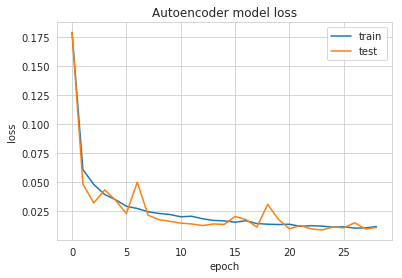

In [85]:
best_loss_value_ann_2h_unisoftsigbinlosadam2 = plot_hist_auto(hist_ann_2h_unisoftsigbinlosadam2, './Figures/ann_2h_unisoftsigbinlosadam2.png')

In [86]:
pred_ann_2h_prob_unisoftsigbinlosadam2, pred_ann_2h_01_unisoftsigbinlosadam2 = ann_predict(ann_2h_unisoftsigbinlosadam2,enc_test_x_asal)

Overall accuracy of Neural Network model: 0.9961397747241667
              precision    recall  f1-score   support

           0       1.00      0.99      1.00     52145
           1       0.99      1.00      1.00     51994

   micro avg       1.00      1.00      1.00    104139
   macro avg       1.00      1.00      1.00    104139
weighted avg       1.00      1.00      1.00    104139



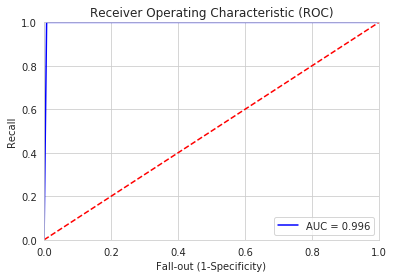

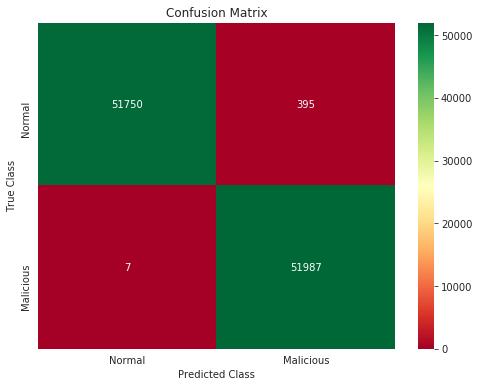

In [87]:
plot_roc_cm(pred_ann_2h_01_unisoftsigbinlosadam2, pred_ann_2h_01_unisoftsigbinlosadam2, './Figures/ROC_ann_2h_unisoftsigbinlosadam2_redds10bal.png', './Figures/CM_ann_2h_unisoftsigbinlosadam2_redds10bal.png')

In [88]:
ann_2h_unisoftsigbinlosadam3 = ann_2h(neurons=120,
                                      encoded_train_x=enc_train_x_asam,
                                      init_mode='uniform',
                                      activation_input='relu',
                                      weight_constraint=5,
                                      dropout_rate=0.0,
                                      activation_output='sigmoid',
                                      loss='binary_crossentropy',
                                      optimizer='Adam')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_22 (Dense)             (None, 120)               9720      
_________________________________________________________________
dense_23 (Dense)             (None, 90)                10890     
_________________________________________________________________
dense_24 (Dense)             (None, 60)                5460      
_________________________________________________________________
batch_normalization_6 (Batch (None, 60)                240       
_________________________________________________________________
dropout_6 (Dropout)          (None, 60)                0         
_________________________________________________________________
dense_25 (Dense)             (None, 1)                 61        
Total params: 26,371
Trainable params: 26,251
Non-trainable params: 120
_________________________________________________________________
None

In [89]:
hist_ann_2h_unisoftsigbinlosadam3 = ann_fit(checkpoint_file = "ann_2h_unisoftsigbinlosadam3_redds10bal.h5",
                                        ann = ann_2h_unisoftsigbinlosadam3,
                                        enc_train_x = enc_train_x_asam,
                                        train_y = train_y,
                                        epochs = 200,
                                        shuffle = True,
                                        batch_size = 120)

Sun Jun  9 10:57:54 2019
Train on 266593 samples, validate on 66649 samples
Epoch 1/200
266593/266593 [==============================] - 11s 41us/step - loss: 0.1062 - acc: 0.9539 - val_loss: 0.0547 - val_acc: 0.9759
Epoch 2/200
266593/266593 [==============================] - 10s 37us/step - loss: 0.0388 - acc: 0.9836 - val_loss: 0.0392 - val_acc: 0.9825
Epoch 3/200
266593/266593 [==============================] - 10s 37us/step - loss: 0.0300 - acc: 0.9875 - val_loss: 0.0270 - val_acc: 0.9875
Epoch 4/200
266593/266593 [==============================] - 10s 38us/step - loss: 0.0252 - acc: 0.9897 - val_loss: 0.0279 - val_acc: 0.9879
Epoch 5/200
266593/266593 [==============================] - 10s 37us/step - loss: 0.0210 - acc: 0.9915 - val_loss: 0.0236 - val_acc: 0.9902
Epoch 6/200
266593/266593 [==============================] - 10s 37us/step - loss: 0.0185 - acc: 0.9924 - val_loss: 0.0138 - val_acc: 0.9940
Epoch 7/200
266593/266593 [==============================] - 10s 37us/step - l

In [90]:
# hist_ann_2h_unisoftsigbinlosadam.model.get_weights()

Best loss value: 0.006906018504109031


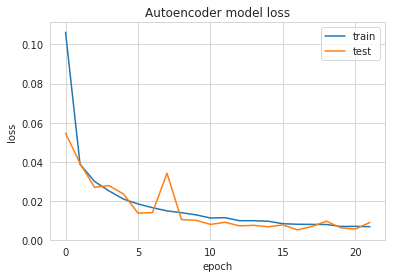

In [91]:
best_loss_value_ann_2h_unisoftsigbinlosadam3 = plot_hist_auto(hist_ann_2h_unisoftsigbinlosadam3, './Figures/ann_2h_unisoftsigbinlosadam3.png')

In [92]:
pred_ann_2h_prob_unisoftsigbinlosadam3, pred_ann_2h_01_unisoftsigbinlosadam3 = ann_predict(ann_2h_unisoftsigbinlosadam3,enc_test_x_asam)

Overall accuracy of Neural Network model: 0.9962165951276659
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     52145
           1       1.00      1.00      1.00     51994

   micro avg       1.00      1.00      1.00    104139
   macro avg       1.00      1.00      1.00    104139
weighted avg       1.00      1.00      1.00    104139



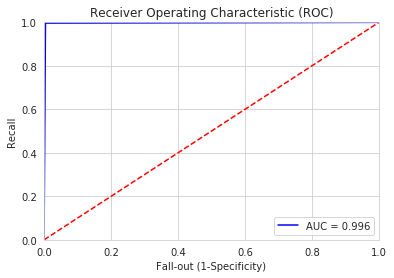

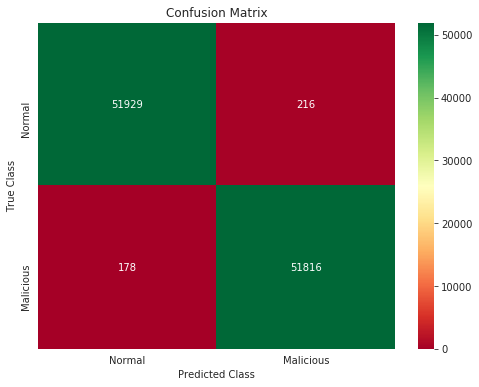

In [93]:
plot_roc_cm(pred_ann_2h_01_unisoftsigbinlosadam3, pred_ann_2h_01_unisoftsigbinlosadam3, './Figures/ROC_ann_2h_unisoftsigbinlosadam3_redds10bal.png', './Figures/CM_ann_2h_unisoftsigbinlosadam3_redds10bal.png')

#### >>>>>>>>>>>>>>>>>>>

In [94]:
ann_2h_unisoftsigbinlosadam4 = ann_2h(neurons=120,
                                      encoded_train_x=enc_train_x_asal,
                                      init_mode='uniform',
                                      activation_input='relu',
                                      weight_constraint=5,
                                      dropout_rate=0.0,
                                      activation_output='sigmoid',
                                      loss='binary_crossentropy',
                                      optimizer='Adam')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_26 (Dense)             (None, 120)               9720      
_________________________________________________________________
dense_27 (Dense)             (None, 90)                10890     
_________________________________________________________________
dense_28 (Dense)             (None, 60)                5460      
_________________________________________________________________
batch_normalization_7 (Batch (None, 60)                240       
_________________________________________________________________
dropout_7 (Dropout)          (None, 60)                0         
_________________________________________________________________
dense_29 (Dense)             (None, 1)                 61        
Total params: 26,371
Trainable params: 26,251
Non-trainable params: 120
_________________________________________________________________
None

In [95]:
hist_ann_2h_unisoftsigbinlosadam4 = ann_fit(checkpoint_file = "ann_2h_unisoftsigbinlosadam4_redds10bal.h5",
                                        ann = ann_2h_unisoftsigbinlosadam4,
                                        enc_train_x = enc_train_x_asal,
                                        train_y = train_y,
                                        epochs = 200,
                                        shuffle = True,
                                        batch_size = 120)

Sun Jun  9 11:01:36 2019
Train on 266593 samples, validate on 66649 samples
Epoch 1/200
266593/266593 [==============================] - 11s 42us/step - loss: 0.1002 - acc: 0.9569 - val_loss: 0.0402 - val_acc: 0.9835
Epoch 2/200
266593/266593 [==============================] - 10s 38us/step - loss: 0.0366 - acc: 0.9843 - val_loss: 0.0241 - val_acc: 0.9899
Epoch 3/200
266593/266593 [==============================] - 10s 38us/step - loss: 0.0304 - acc: 0.9872 - val_loss: 0.0188 - val_acc: 0.9922
Epoch 4/200
266593/266593 [==============================] - 10s 38us/step - loss: 0.0238 - acc: 0.9903 - val_loss: 0.0420 - val_acc: 0.9814
Epoch 5/200
266593/266593 [==============================] - 10s 38us/step - loss: 0.0208 - acc: 0.9915 - val_loss: 0.0158 - val_acc: 0.9929
Epoch 6/200
266593/266593 [==============================] - 10s 37us/step - loss: 0.0182 - acc: 0.9923 - val_loss: 0.0130 - val_acc: 0.9942
Epoch 7/200
266593/266593 [==============================] - 10s 37us/step - l

In [96]:
# hist_ann_2h_unisoftsigbinlosadam.model.get_weights()

Best loss value: 0.005873313173321294


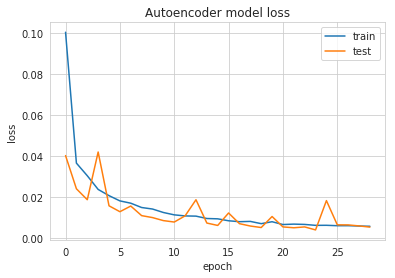

In [97]:
best_loss_value_ann_2h_unisoftsigbinlosadam4 = plot_hist_auto(hist_ann_2h_unisoftsigbinlosadam4, './Figures/ann_2h_unisoftsigbinlosadam4.png')

In [140]:
pred_ann_2h_prob_unisoftsigbinlosadam4, pred_ann_2h_01_unisoftsigbinlosadam4 = ann_predict(ann_2h_unisoftsigbinlosadam4,enc_test_x_asal)

Overall accuracy of Neural Network model: 0.9981755154168948
              precision    recall  f1-score   support

           0     0.9998    0.9965    0.9982     52145
           1     0.9965    0.9998    0.9982     51994

   micro avg     0.9982    0.9982    0.9982    104139
   macro avg     0.9982    0.9982    0.9982    104139
weighted avg     0.9982    0.9982    0.9982    104139



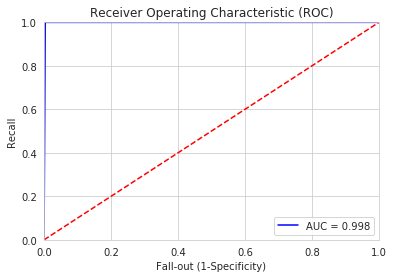

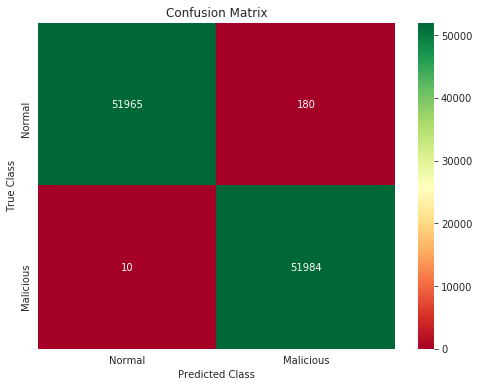

In [99]:
plot_roc_cm(pred_ann_2h_01_unisoftsigbinlosadam4, pred_ann_2h_01_unisoftsigbinlosadam4, './Figures/ROC_ann_2h_unisoftsigbinlosadam4_redds10bal.png', './Figures/CM_ann_2h_unisoftsigbinlosadam4_redds10bal.png')

ann_2h__(neurons,encoded_train_x,activation_input,
               dropout_rate,activation_output,
               loss,optimizer)

In [100]:
ann_2h_unisoftsigbinlosadam5 = ann_2h__(neurons=120,
                                      encoded_train_x=enc_train_x_asal,
                                      activation_input='relu',
#                                       dropout_rate=0.0,
                                      activation_output='sigmoid',
                                      loss='binary_crossentropy',
                                      optimizer='Adam')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_30 (Dense)             (None, 120)               9720      
_________________________________________________________________
dense_31 (Dense)             (None, 90)                10890     
_________________________________________________________________
dense_32 (Dense)             (None, 60)                5460      
_________________________________________________________________
dense_33 (Dense)             (None, 1)                 61        
Total params: 26,131
Trainable params: 26,131
Non-trainable params: 0
_________________________________________________________________
None


In [101]:
hist_ann_2h_unisoftsigbinlosadam5 = ann_fit(checkpoint_file = "ann_2h_unisoftsigbinlosadam5_redds10bal.h5",
                                        ann = ann_2h_unisoftsigbinlosadam5,
                                        enc_train_x = enc_train_x_asal,
                                        train_y = train_y,
                                        epochs = 200,
                                        shuffle = True,
                                        batch_size = 120)

Sun Jun  9 11:06:28 2019
Train on 266593 samples, validate on 66649 samples
Epoch 1/200
266593/266593 [==============================] - 9s 32us/step - loss: 0.1195 - acc: 0.9481 - val_loss: 0.0284 - val_acc: 0.9883
Epoch 2/200
266593/266593 [==============================] - 8s 29us/step - loss: 0.0281 - acc: 0.9886 - val_loss: 0.0237 - val_acc: 0.9898
Epoch 3/200
266593/266593 [==============================] - 8s 29us/step - loss: 0.0212 - acc: 0.9911 - val_loss: 0.0164 - val_acc: 0.9934
Epoch 4/200
266593/266593 [==============================] - 8s 29us/step - loss: 0.0187 - acc: 0.9923 - val_loss: 0.0146 - val_acc: 0.9940
Epoch 5/200
266593/266593 [==============================] - 8s 28us/step - loss: 0.0163 - acc: 0.9932 - val_loss: 0.0179 - val_acc: 0.9919
Epoch 6/200
266593/266593 [==============================] - 8s 29us/step - loss: 0.0146 - acc: 0.9939 - val_loss: 0.0320 - val_acc: 0.9910
Epoch 7/200
266593/266593 [==============================] - 8s 29us/step - loss: 0.

In [102]:
# hist_ann_2h_unisoftsigbinlosadam.model.get_weights()

Best loss value: 0.004642843747757022


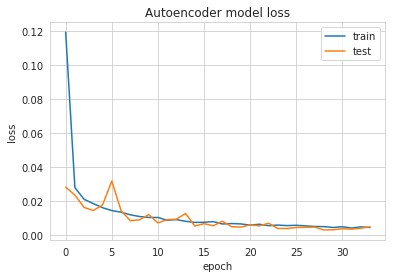

In [103]:
best_loss_value_ann_2h_unisoftsigbinlosadam5 = plot_hist_auto(hist_ann_2h_unisoftsigbinlosadam5, './Figures/ann_2h_unisoftsigbinlosadam5.png')

In [143]:
pred_ann_2h_prob_unisoftsigbinlosadam5, pred_ann_2h_01_unisoftsigbinlosadam5 = ann_predict(ann_2h_unisoftsigbinlosadam5,enc_test_x_asal)

Overall accuracy of Neural Network model: 0.9978202210507111
              precision    recall  f1-score   support

           0     0.9985    0.9971    0.9978     52145
           1     0.9971    0.9985    0.9978     51994

   micro avg     0.9978    0.9978    0.9978    104139
   macro avg     0.9978    0.9978    0.9978    104139
weighted avg     0.9978    0.9978    0.9978    104139



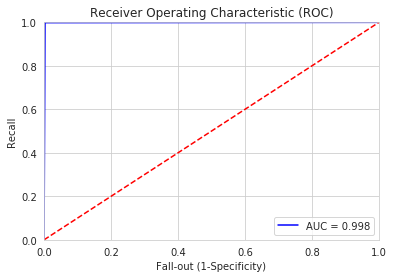

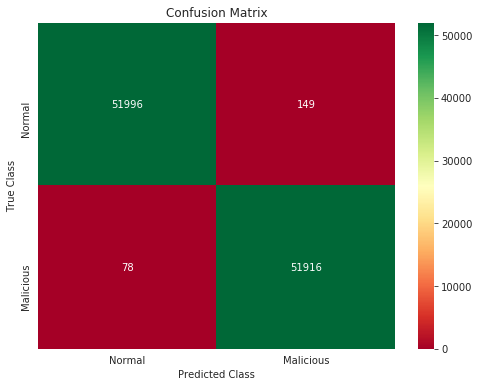

In [105]:
plot_roc_cm(pred_ann_2h_01_unisoftsigbinlosadam5, pred_ann_2h_01_unisoftsigbinlosadam5, './Figures/ROC_ann_2h_unisoftsigbinlosadam5_redds10bal.png', './Figures/CM_ann_2h_unisoftsigbinlosadam5_redds10bal.png')

In [106]:
ann_2h_unisoftsigbinlosadam6 = ann_2h__(neurons=120,
                                      encoded_train_x=enc_train_x_asam,
                                      activation_input='relu',
#                                       dropout_rate=0.0,
                                      activation_output='sigmoid',
                                      loss='binary_crossentropy',
                                      optimizer='Adam')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_34 (Dense)             (None, 120)               9720      
_________________________________________________________________
dense_35 (Dense)             (None, 90)                10890     
_________________________________________________________________
dense_36 (Dense)             (None, 60)                5460      
_________________________________________________________________
dense_37 (Dense)             (None, 1)                 61        
Total params: 26,131
Trainable params: 26,131
Non-trainable params: 0
_________________________________________________________________
None


In [107]:
hist_ann_2h_unisoftsigbinlosadam6 = ann_fit(checkpoint_file = "ann_2h_unisoftsigbinlosadam6_redds10bal.h5",
                                        ann = ann_2h_unisoftsigbinlosadam6,
                                        enc_train_x = enc_train_x_asam,
                                        train_y = train_y,
                                        epochs = 200,
                                        shuffle = True,
                                        batch_size = 120)

Sun Jun  9 11:10:49 2019
Train on 266593 samples, validate on 66649 samples
Epoch 1/200
266593/266593 [==============================] - 9s 32us/step - loss: 0.1171 - acc: 0.9491 - val_loss: 0.0354 - val_acc: 0.9844
Epoch 2/200
266593/266593 [==============================] - 8s 29us/step - loss: 0.0305 - acc: 0.9875 - val_loss: 0.0275 - val_acc: 0.9877
Epoch 3/200
266593/266593 [==============================] - 8s 28us/step - loss: 0.0220 - acc: 0.9910 - val_loss: 0.0209 - val_acc: 0.9906
Epoch 4/200
266593/266593 [==============================] - 8s 29us/step - loss: 0.0176 - acc: 0.9927 - val_loss: 0.0137 - val_acc: 0.9943
Epoch 5/200
266593/266593 [==============================] - 8s 29us/step - loss: 0.0160 - acc: 0.9935 - val_loss: 0.0138 - val_acc: 0.9941
Epoch 6/200
266593/266593 [==============================] - 8s 29us/step - loss: 0.0137 - acc: 0.9944 - val_loss: 0.0100 - val_acc: 0.9953
Epoch 7/200
266593/266593 [==============================] - 8s 29us/step - loss: 0.

In [108]:
# hist_ann_2h_unisoftsigbinlosadam.model.get_weights()

Best loss value: 0.00644507435834564


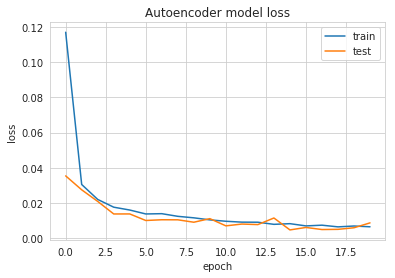

In [109]:
best_loss_value_ann_2h_unisoftsigbinlosadam6 = plot_hist_auto(hist_ann_2h_unisoftsigbinlosadam6, './Figures/ann_2h_unisoftsigbinlosadam6.png')

In [142]:
pred_ann_2h_prob_unisoftsigbinlosadam6, pred_ann_2h_01_unisoftsigbinlosadam6 = ann_predict(ann_2h_unisoftsigbinlosadam6,enc_test_x_asam)

Overall accuracy of Neural Network model: 0.9966487098973488
              precision    recall  f1-score   support

           0     0.9970    0.9963    0.9967     52145
           1     0.9963    0.9970    0.9966     51994

   micro avg     0.9966    0.9966    0.9966    104139
   macro avg     0.9966    0.9966    0.9966    104139
weighted avg     0.9966    0.9966    0.9966    104139



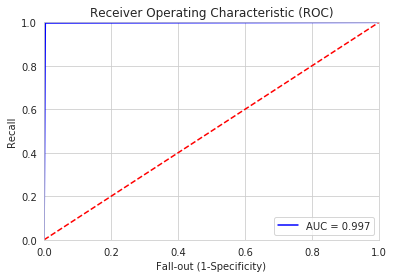

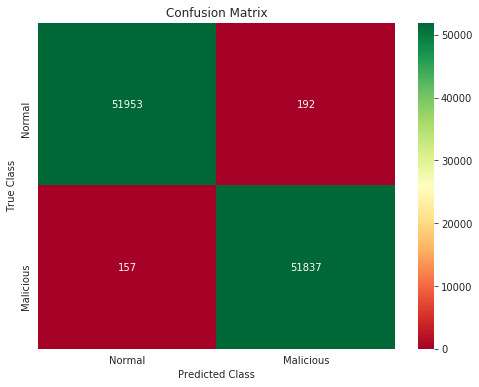

In [111]:
plot_roc_cm(pred_ann_2h_01_unisoftsigbinlosadam6, pred_ann_2h_01_unisoftsigbinlosadam6, './Figures/ROC_ann_2h_unisoftsigbinlosadam6_redds10bal.png', './Figures/CM_ann_2h_unisoftsigbinlosadam6_redds10bal.png')

In [112]:
enc_train_x_assal.shape

(333242, 80)

In [113]:
ann_2h_unisoftsigbinlosadam7 = ann_2h__(neurons=120,
                                      encoded_train_x=enc_train_x_asal,
                                      activation_input='tanh',
#                                       dropout_rate=0.0,
                                      activation_output='sigmoid',
                                      loss='binary_crossentropy',
                                      optimizer='Adam')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_38 (Dense)             (None, 120)               9720      
_________________________________________________________________
dense_39 (Dense)             (None, 90)                10890     
_________________________________________________________________
dense_40 (Dense)             (None, 60)                5460      
_________________________________________________________________
dense_41 (Dense)             (None, 1)                 61        
Total params: 26,131
Trainable params: 26,131
Non-trainable params: 0
_________________________________________________________________
None


In [114]:
hist_ann_2h_unisoftsigbinlosadam7 = ann_fit(checkpoint_file = "ann_2h_unisoftsigbinlosadam7_redds10bal.h5",
                                        ann = ann_2h_unisoftsigbinlosadam7,
                                        enc_train_x = enc_train_x_asal,
                                        train_y = train_y,
                                        epochs = 200,
                                        shuffle = True,
                                        batch_size = 120)

Sun Jun  9 11:13:27 2019
Train on 266593 samples, validate on 66649 samples
Epoch 1/200
266593/266593 [==============================] - 9s 33us/step - loss: 0.1458 - acc: 0.9389 - val_loss: 0.0373 - val_acc: 0.9855
Epoch 2/200
266593/266593 [==============================] - 8s 29us/step - loss: 0.0349 - acc: 0.9860 - val_loss: 0.0309 - val_acc: 0.9865
Epoch 3/200
266593/266593 [==============================] - 8s 29us/step - loss: 0.0262 - acc: 0.9892 - val_loss: 0.0271 - val_acc: 0.9887
Epoch 4/200
266593/266593 [==============================] - 8s 29us/step - loss: 0.0220 - acc: 0.9910 - val_loss: 0.0196 - val_acc: 0.9915
Epoch 5/200
266593/266593 [==============================] - 8s 30us/step - loss: 0.0190 - acc: 0.9921 - val_loss: 0.0180 - val_acc: 0.9937
Epoch 6/200
266593/266593 [==============================] - 8s 29us/step - loss: 0.0173 - acc: 0.9931 - val_loss: 0.0250 - val_acc: 0.9905
Epoch 7/200
266593/266593 [==============================] - 8s 29us/step - loss: 0.

In [115]:
# hist_ann_2h_unisoftsigbinlosadam.model.get_weights()

Best loss value: 0.010282997018918993


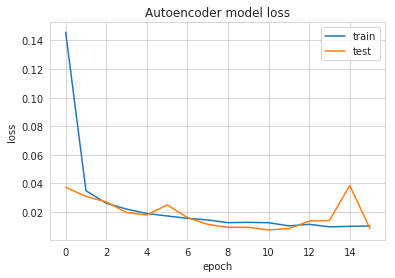

In [116]:
best_loss_value_ann_2h_unisoftsigbinlosadam7 = plot_hist_auto(hist_ann_2h_unisoftsigbinlosadam7, './Figures/ann_2h_unisoftsigbinlosadam7.png')

In [139]:
pred_ann_2h_prob_unisoftsigbinlosadam7, pred_ann_2h_01_unisoftsigbinlosadam7 = ann_predict(ann_2h_unisoftsigbinlosadam7,enc_test_x_asal)

Overall accuracy of Neural Network model: 0.9950450839743036
              precision    recall  f1-score   support

           0     0.9939    0.9962    0.9951     52145
           1     0.9962    0.9939    0.9950     51994

   micro avg     0.9950    0.9950    0.9950    104139
   macro avg     0.9950    0.9950    0.9950    104139
weighted avg     0.9950    0.9950    0.9950    104139



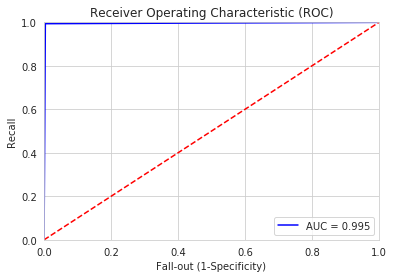

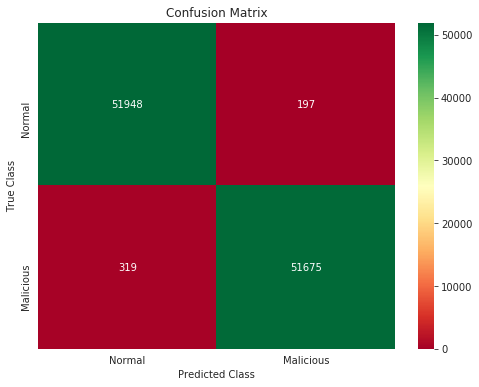

In [118]:
plot_roc_cm(pred_ann_2h_01_unisoftsigbinlosadam7, pred_ann_2h_01_unisoftsigbinlosadam7, './Figures/ROC_ann_2h_unisoftsigbinlosadam7_redds10bal.png', './Figures/CM_ann_2h_unisoftsigbinlosadam7_redds10bal.png')

In [119]:
from keras.utils import to_categorical
train_y_ = to_categorical(train_y)

In [120]:
ann_2h_unisoftsigbinlosadam8 = ann_2h__(neurons=120,
                                      encoded_train_x=enc_train_x_asal,
                                      activation_input='tanh',
#                                       dropout_rate=0.0,
                                      activation_output='sigmoid',
                                      loss='mean_squared_error',
                                      optimizer='Adam')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_42 (Dense)             (None, 120)               9720      
_________________________________________________________________
dense_43 (Dense)             (None, 90)                10890     
_________________________________________________________________
dense_44 (Dense)             (None, 60)                5460      
_________________________________________________________________
dense_45 (Dense)             (None, 1)                 61        
Total params: 26,131
Trainable params: 26,131
Non-trainable params: 0
_________________________________________________________________
None


In [121]:
hist_ann_2h_unisoftsigbinlosadam8 = ann_fit(checkpoint_file = "ann_2h_unisoftsigbinlosadam8_redds10bal.h5",
                                        ann = ann_2h_unisoftsigbinlosadam8,
                                        enc_train_x = enc_train_x_asal,
                                        train_y = train_y,
                                        epochs = 200,
                                        shuffle = True,
                                        batch_size = 120)

Sun Jun  9 11:15:36 2019
Train on 266593 samples, validate on 66649 samples
Epoch 1/200
266593/266593 [==============================] - 8s 31us/step - loss: 0.0494 - acc: 0.9373 - val_loss: 0.0164 - val_acc: 0.9811
Epoch 2/200
266593/266593 [==============================] - 7s 27us/step - loss: 0.0157 - acc: 0.9819 - val_loss: 0.0129 - val_acc: 0.9857
Epoch 3/200
266593/266593 [==============================] - 7s 27us/step - loss: 0.0139 - acc: 0.9841 - val_loss: 0.0141 - val_acc: 0.9829
Epoch 4/200
266593/266593 [==============================] - 7s 27us/step - loss: 0.0119 - acc: 0.9862 - val_loss: 0.0103 - val_acc: 0.9883
Epoch 5/200
266593/266593 [==============================] - 7s 27us/step - loss: 0.0111 - acc: 0.9872 - val_loss: 0.0101 - val_acc: 0.9886
Epoch 6/200
266593/266593 [==============================] - 7s 26us/step - loss: 0.0104 - acc: 0.9880 - val_loss: 0.0105 - val_acc: 0.9880
Epoch 7/200
266593/266593 [==============================] - 7s 26us/step - loss: 0.

In [122]:
# hist_ann_2h_unisoftsigbinlosadam.model.get_weights()

Best loss value: 0.006453172000474337


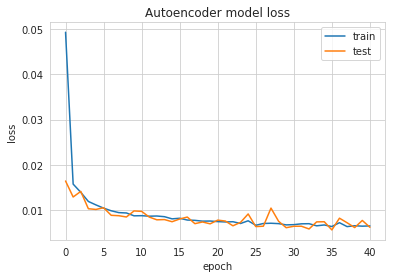

In [123]:
best_loss_value_ann_2h_unisoftsigbinlosadam8 = plot_hist_auto(hist_ann_2h_unisoftsigbinlosadam8, './Figures/ann_2h_unisoftsigbinlosadam8.png')

In [138]:
pred_ann_2h_prob_unisoftsigbinlosadam8, pred_ann_2h_01_unisoftsigbinlosadam8 = ann_predict(ann_2h_unisoftsigbinlosadam8,enc_test_x_asal)

Overall accuracy of Neural Network model: 0.9932109968407609
              precision    recall  f1-score   support

           0     0.9928    0.9937    0.9932     52145
           1     0.9936    0.9928    0.9932     51994

   micro avg     0.9932    0.9932    0.9932    104139
   macro avg     0.9932    0.9932    0.9932    104139
weighted avg     0.9932    0.9932    0.9932    104139



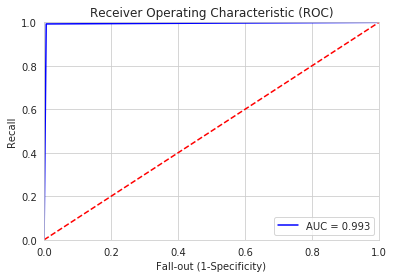

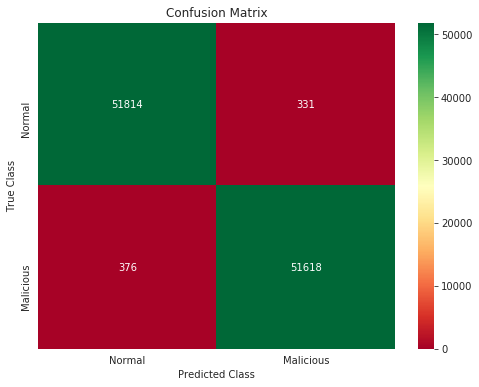

In [125]:
plot_roc_cm(pred_ann_2h_01_unisoftsigbinlosadam8, pred_ann_2h_01_unisoftsigbinlosadam8, './Figures/ROC_ann_2h_unisoftsigbinlosadam8_redds10bal.png', './Figures/CM_ann_2h_unisoftsigbinlosadam8_redds10bal.png')

In [126]:
ann_24n_unisoftsigbinlosadam = ann_1h_24n(neurons=120,
                                      encoded_train_x=train_x,
                                      init_mode='uniform',
                                      activation_input='softsign',
                                      weight_constraint=5,
                                      dropout_rate=0.0,
                                      activation_output='sigmoid',
                                      loss='binary_crossentropy',
                                      optimizer='Adam')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_46 (Dense)             (None, 120)               14520     
_________________________________________________________________
dense_47 (Dense)             (None, 60)                7260      
_________________________________________________________________
batch_normalization_8 (Batch (None, 60)                240       
_________________________________________________________________
dropout_8 (Dropout)          (None, 60)                0         
_________________________________________________________________
dense_48 (Dense)             (None, 1)                 61        
Total params: 22,081
Trainable params: 21,961
Non-trainable params: 120
_________________________________________________________________
None


In [127]:
hist_ann_24n_unisoftsigbinlosadam = ann_fit(checkpoint_file = "ann_24n_unisoftsigbinlosadam_redds10bal.h5",
                                        ann = ann_24n_unisoftsigbinlosadam,
                                        enc_train_x = train_x,
                                        train_y = train_y,
                                        epochs = 200,
                                        shuffle = True,
                                        batch_size = 120)

Sun Jun  9 11:20:30 2019
Train on 266593 samples, validate on 66649 samples
Epoch 1/200
266593/266593 [==============================] - 12s 46us/step - loss: 0.0629 - acc: 0.9761 - val_loss: 0.0240 - val_acc: 0.9905
Epoch 2/200
266593/266593 [==============================] - 11s 42us/step - loss: 0.0220 - acc: 0.9911 - val_loss: 0.0185 - val_acc: 0.9924
Epoch 3/200
266593/266593 [==============================] - 11s 42us/step - loss: 0.0178 - acc: 0.9926 - val_loss: 0.0153 - val_acc: 0.9937
Epoch 4/200
266593/266593 [==============================] - 11s 42us/step - loss: 0.0166 - acc: 0.9932 - val_loss: 0.0170 - val_acc: 0.9924
Epoch 5/200
266593/266593 [==============================] - 11s 42us/step - loss: 0.0149 - acc: 0.9939 - val_loss: 0.0144 - val_acc: 0.9943
Epoch 6/200
266593/266593 [==============================] - 11s 43us/step - loss: 0.0134 - acc: 0.9945 - val_loss: 0.0136 - val_acc: 0.9948
Epoch 7/200
266593/266593 [==============================] - 11s 42us/step - l

Best loss value: 0.004305214379176668


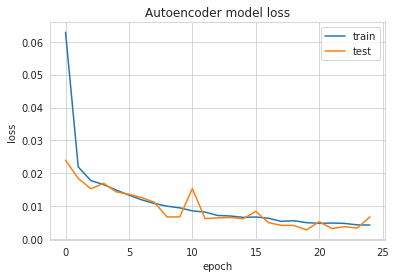

In [128]:
best_loss_value_ann_24n_unisoftsigbinlosadam = plot_hist_auto(hist_ann_24n_unisoftsigbinlosadam, './Figures/ann_24_unisoftsigbinlosadam.png')

In [137]:
pred_ann_24n_prob_unisoftsigbinlosadam, pred_ann_24n_01_unisoftsigbinlosadam = ann_predict(ann_24n_unisoftsigbinlosadam,test_x)

Overall accuracy of Neural Network model: 0.9981371052151451
              precision    recall  f1-score   support

           0     0.9996    0.9967    0.9981     52145
           1     0.9967    0.9996    0.9981     51994

   micro avg     0.9981    0.9981    0.9981    104139
   macro avg     0.9981    0.9981    0.9981    104139
weighted avg     0.9981    0.9981    0.9981    104139



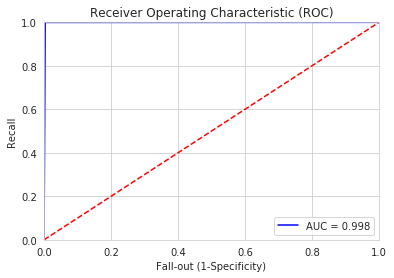

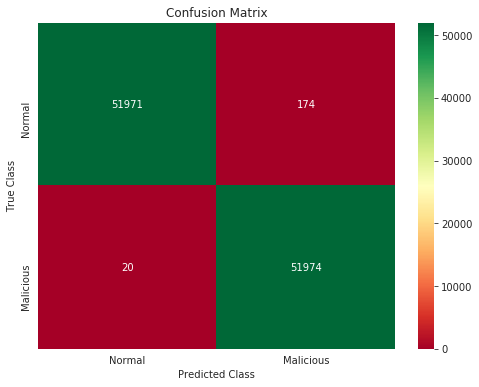

In [130]:
plot_roc_cm(pred_ann_24n_01_unisoftsigbinlosadam, pred_ann_24n_01_unisoftsigbinlosadam, './Figures/ROC_ann_24n_unisoftsigbinlosadam_redds10bal.png', './Figures/CM_ann_24n_unisoftsigbinlosadam_redds10bal.png')

In [131]:
from sklearn.ensemble import RandomForestClassifier

In [132]:
clf = RandomForestClassifier(n_estimators=300, 
                             criterion='gini', 
                             max_depth=16, 
#                              min_samples_split=2, 
                             #min_samples_leaf=1, 
                             max_features=0.3, 
                             #bootstrap=True,
                             oob_score=True,
                             random_state=23)  

In [133]:
start_time = time.time()
print(time.ctime(start_time))

clf.fit(enc_train_x_aslal, train_y)

pred_y_RF = cross_val_predict(estimator=clf,
                              X=np.array(enc_test_x_aslal),
                              y=test_y,
                              cv=KFold(n_splits=10, random_state=23),
                              n_jobs=2)

elapsed_time = (time.time() - start_time)
print("--- %s seconds ---" %elapsed_time)

print(sm.classification_report(test_y, pred_y_RF,digits=4))

Sun Jun  9 11:25:13 2019
--- 5628.137378692627 seconds ---
              precision    recall  f1-score   support

           0     0.9990    0.9990    0.9990     52145
           1     0.9990    0.9990    0.9990     51994

   micro avg     0.9990    0.9990    0.9990    104139
   macro avg     0.9990    0.9990    0.9990    104139
weighted avg     0.9990    0.9990    0.9990    104139



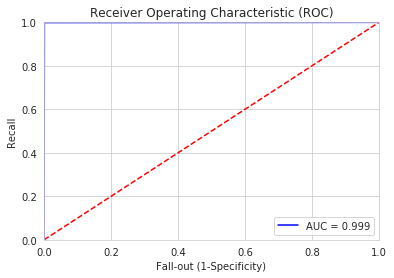

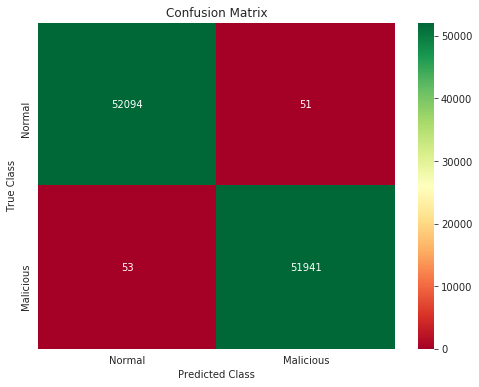

In [134]:
plot_roc_cm(pred_y_RF, pred_y_RF, './Figures/ROC_rf_E100MaxfautoMaxdnoneBootT_redds10bal.png', './Figures/CM_rf_E100MaxfautoMaxdnoneBootT_redds10bal.png')